# Visualize and Evaluate model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import argparse
import os
from os.path import isfile,join
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torch.utils.data as tud
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import jaccard_score
import pickle
import sys
from dataset_utils import MoNuSegDataset
from eval_train import compute_AJI


Bad key "text.kerning_factor" on line 4 in
/usr/lib64/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution





## Parameters

In [3]:
# DATASETS
dataroot_monuseg = '/share/DEEPLEARNING/datasets/monuseg'

model_dir = '/share/homes/karmimy/equiv/save_model/fully_supervised_monuseg/' # Saved model dir
expe ='12'
model_name = 'fully_supervised_monuseg.pt'
folder_model = join(model_dir,expe) 

nw = 4
pm = True
# GPU 
gpu = 1
# EVAL PARAMETERS
bs = 1  

# DEVICE
# Decide which device we want to run on
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
print("device :",device)

device : cuda:1


In [4]:
model = torch.load(join(folder_model,model_name),map_location=device)


## DATASETS

In [5]:
test_dataset_aji = MoNuSegDataset(dataroot_monuseg,image_set='test',load_entire_image=True,binary=False)
test_dataset = MoNuSegDataset(dataroot_monuseg,image_set='test',load_entire_image=True,binary=True)
        


## Plot Losses and Metrics 

In [6]:
def plot_loss_metrics(folder,model_name):
    l_npy = [f for f in os.listdir(folder) if isfile(join(folder,f)) and f.endswith(".npy")] # Load all numpy file in the best folder
    for f in l_npy:
        curv = np.load(join(folder,f))
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.title(model_name.upper())
        plt.plot(curv)
        plt.xlabel("iterations")
        plt.ylabel(f.upper())



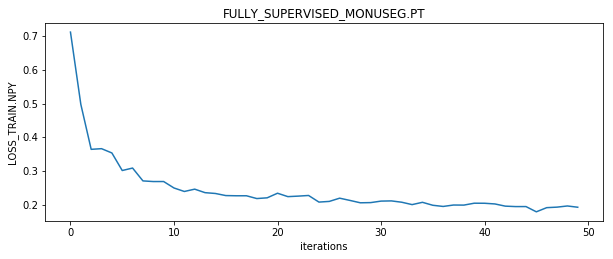

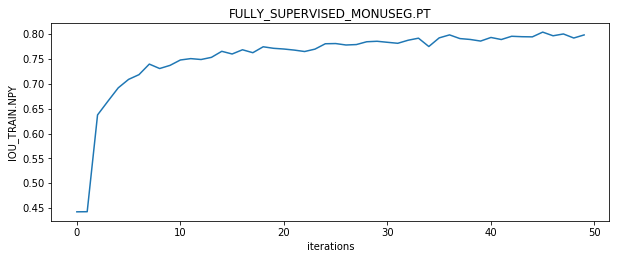

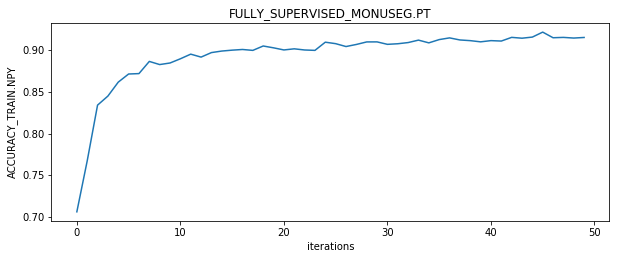

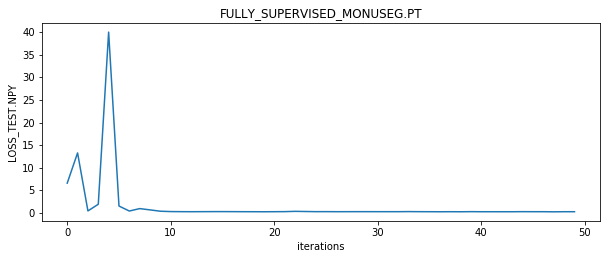

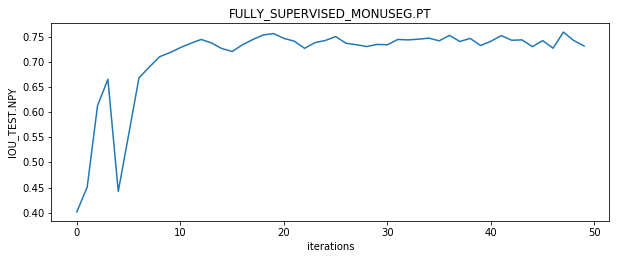

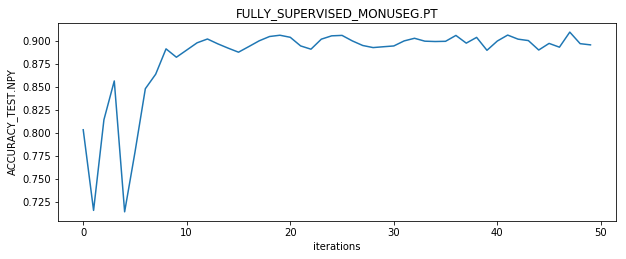

In [7]:
plot_loss_metrics(folder_model,model_name)

## SHOW MODEL PREDICTIONS

In [8]:
# PARAMETERS FOR THE VISUALIZATION 
NUMBER_EXAMPLES = 20
list_iter = np.random.randint(0,len(test_dataset),NUMBER_EXAMPLES) # TAKE N RANDOM IMAGES 
CLASS = U.LANDCOVER_CLASS
CMAP = U.get_cmap_landcover()

NameError: name 'U' is not defined

ITERATION 0 / 20
Metrics on this example... IoU: 0.4906349182128906 Accuracy tensor(0.9813)
ITERATION 1 / 20
Metrics on this example... IoU: 0.5219330720673826 Accuracy tensor(0.9072)
ITERATION 2 / 20
Metrics on this example... IoU: 0.4904168531077707 Accuracy tensor(0.9730)
ITERATION 3 / 20
Metrics on this example... IoU: 0.48537445068359375 Accuracy tensor(0.9707)
ITERATION 4 / 20
Metrics on this example... IoU: 0.4221201041733229 Accuracy tensor(0.8476)
ITERATION 5 / 20
Metrics on this example... IoU: 0.5918330003920252 Accuracy tensor(0.9515)
ITERATION 6 / 20
Metrics on this example... IoU: 1.0 Accuracy tensor(1.)
ITERATION 7 / 20
Metrics on this example... IoU: 0.574775600307203 Accuracy tensor(0.7610)
ITERATION 8 / 20
Metrics on this example... IoU: 0.4998912811279297 Accuracy tensor(0.9998)
ITERATION 9 / 20
Metrics on this example... IoU: 0.32512707181818634 Accuracy tensor(0.8067)
ITERATION 10 / 20
Metrics on this example... IoU: 0.48368072509765625 Accuracy tensor(0.9674)
ITER

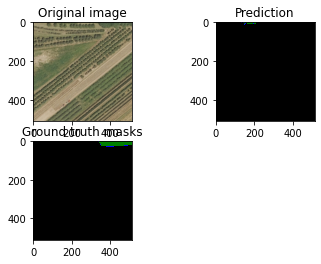

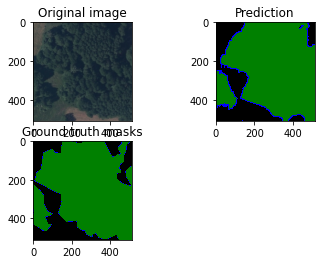

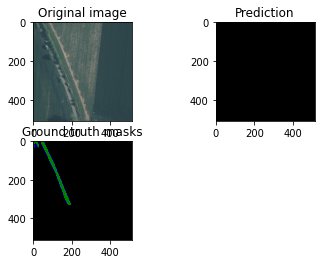

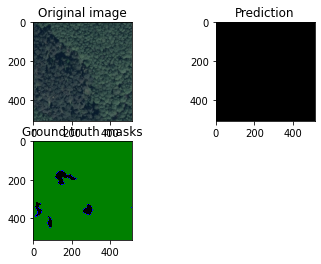

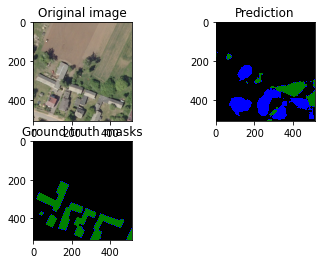

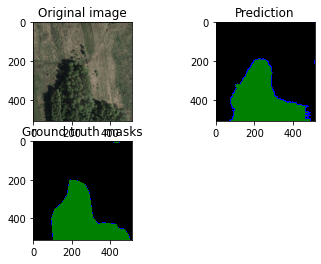

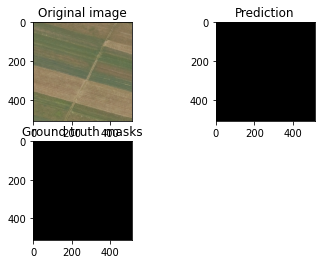

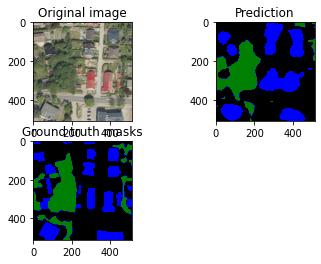

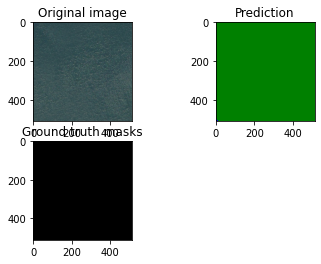

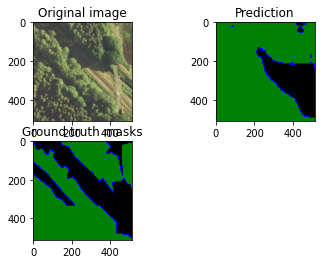

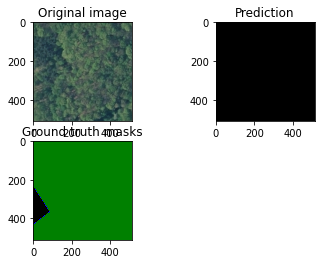

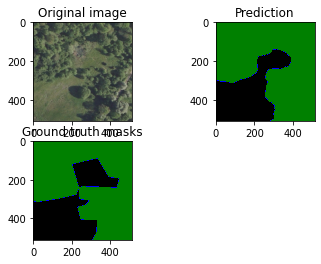

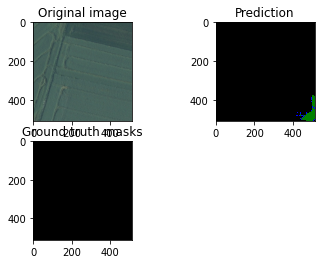

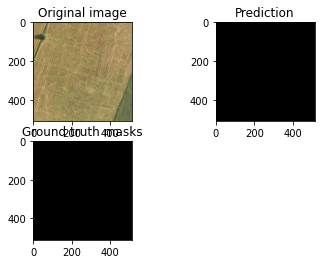

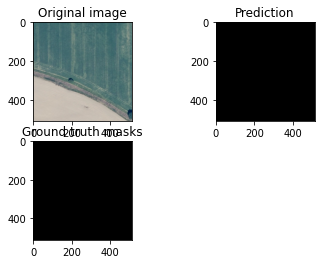

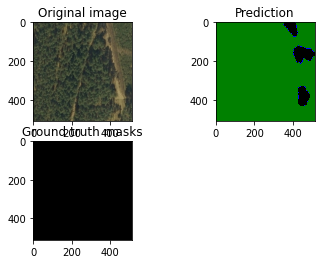

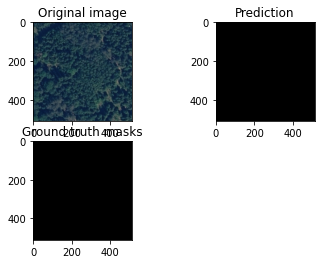

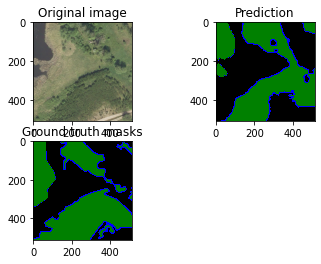

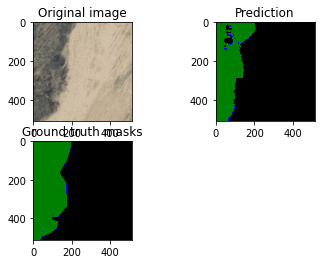

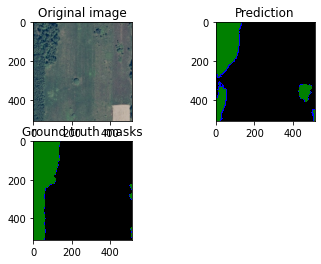

In [14]:
l_iou=[]
l_acc=[]
for i,im in enumerate(list_iter):
    print('ITERATION',i,'/',NUMBER_EXAMPLES)
    x,gt = test_dataset.__getitem__(im)
    im,_ = test_dataset_no_norm.__getitem__(im)
    x = x.unsqueeze(0).to(device)
    pred = model(x)
    pred = pred['out']

    #plot
    im = torch.transpose(im,0,2)
    im = torch.transpose(im,0,1)
    pred = pred.argmax(dim=1).squeeze().cpu()
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.title.set_text('Original image')
    ax1.imshow(im.cpu(),cmap=CMAP)
    ax2 = fig.add_subplot(2,2,2)
    ax2.title.set_text('Prediction')
    ax2.imshow(pred,cmap=CMAP)
    ax3 = fig.add_subplot(2,2,3)
    ax3.title.set_text('Ground truth masks')
    ax3.imshow(gt.cpu(),cmap=CMAP)
    
    # Metrics 
    iou = U.inter_over_union(pred,gt)
    acc = torch.sum(pred==gt).float()/(pred.size()[0]*pred.size()[1])
    l_iou.append(iou)
    l_acc.append(acc)
    print("Metrics on this example... IoU:",iou,"Accuracy",acc)
print("Mean IoU",np.array(l_iou).mean(),"Mean Accuracy",np.array(l_acc).mean())

## EVAL IoU ALL ANGLES

In [9]:
state = ev.eval_model(model,dataloader_val,device=device,num_classes=num_classes)
iou = state.metrics['mean IoU']
acc = state.metrics['accuracy']
loss = state.metrics['CE Loss']

In [10]:
iou

0.678422692700825

In [6]:
dataloader_val = torch.utils.data.DataLoader(test_dataset_aji,num_workers=nw,pin_memory=pm,\
        batch_size=bs)
aji,aji_mean = compute_AJI(model,dataloader_val,device,dist_factor=0.3,threshold=54,clean_prediction=False,it_bg=0,it_opening=0)
print(aji_mean)

0.5552409816985633


In [8]:
l_angles = [180,210,240,270,300,330,0,30,60,90,120,150]
l_iou = []
for angle in l_angles:
    test_dataset_aji = MoNuSegDataset(dataroot_monuseg,image_set='test',load_entire_image=True,binary=False,fixing_rotate=True,angle_fix=angle)
    dataloader_val = torch.utils.data.DataLoader(test_dataset_aji,num_workers=nw,pin_memory=pm,\
        batch_size=bs)
    aji,aji_mean = compute_AJI(model,dataloader_val,device,dist_factor=0.3,threshold=54,clean_prediction=False,it_bg=0,it_opening=0)
    print('EVAL FOR ANGLE',angle,': AJI',aji_mean)


EVAL FOR ANGLE 180 : AJI 0.5447027408273222
EVAL FOR ANGLE 210 : AJI 0.49844162668551145
EVAL FOR ANGLE 240 : AJI 0.50391762563946
EVAL FOR ANGLE 270 : AJI 0.5489654378504765
EVAL FOR ANGLE 300 : AJI 0.5091966725977652
EVAL FOR ANGLE 330 : AJI 0.5060083817520971
EVAL FOR ANGLE 0 : AJI 0.5545805950589698
EVAL FOR ANGLE 30 : AJI 0.50979832588279
EVAL FOR ANGLE 60 : AJI 0.5128509982307142
EVAL FOR ANGLE 90 : AJI 0.553742556812619
EVAL FOR ANGLE 120 : AJI 0.5100792049705821
EVAL FOR ANGLE 150 : AJI 0.50308217144061


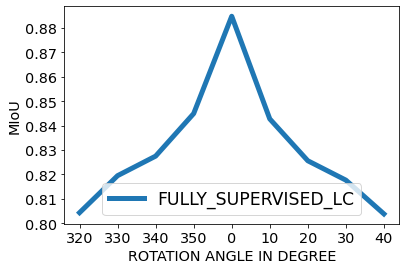

In [25]:
l_angles = [str(i) for i in l_angles] 
plt.figure()
#plt.title('Evolution of the IoU VAL VOC 2012 according to the rotation of the input images.')
plt.plot(l_angles,l_iou,label=exp.upper(),linewidth=5.0)
#plt.plot(angle,fcn_multi_task_val,label='FCN multi-tasks '+r'$\mathcal{LE}_{CE}$',linewidth=5.0)
#plt.plot(angle,fcn_semisup_val,label='FCN semi-sup '+r'$\mathcal{LE}_{CE}$',linewidth=5.0)
#plt.plot(angle,fcn_semisup_val_KL,label='(Ours) FCN semi-sup '+r'$\mathcal{LE}_{KL}$',linewidth=5.0)
#plt.plot(angle,fcn_rot_sup_val,"--",label='FCN Rot*',linewidth=5.0)
##plt.plot(angle,fcn_sup_rot_val,label='fcn_sup rotation data aug')
plt.xlabel("ROTATION ANGLE IN DEGREE",fontsize='x-large')
plt.ylabel("MIoU",fontsize='x-large')
plt.legend(loc="lower center",fontsize='xx-large')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.show()